# 1. Import and Install Dependencies

In [1]:
!pip install tensorflow==2.15 opencv-python mediapipe scikit-learn matplotlib opencv-python-headless pymongo seaborn

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [229]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
from pymongo import MongoClient

# 2. Keypoints using MP Holistic

In [114]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [115]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [116]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2))

In [135]:
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: No se pudo acceder a la cámara.")
    cap.release()
    exit()

    # Capture data
with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        ret, frame = cap.read()

        # make detections on frames
        image, results = mediapipe_detection(frame, holistic)

        draw_styled_landmarks(image, results)

        # draw detections
        cv2.imshow('OpenCV Feed', image)

        # Salir si se presiona 'q'
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [136]:
draw_styled_landmarks(image, results)


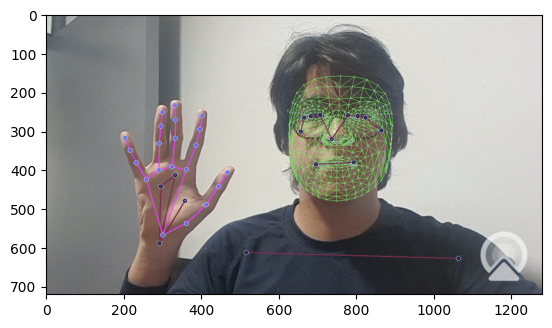

In [137]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

# 3. Extract Keypoint Values

In [138]:
len(results.right_hand_landmarks.landmark)

21

In [147]:
def extract_keypoints(results):
    """
    Extract keypoints in pose, face and hands
    """
    # Pose landmarks: 33 points * 3 coords = 99
    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() \
        if results.pose_landmarks else np.zeros(33 * 3)
    
    # Face landmarks: 468 points * 3 coords = 1404
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() \
        if results.face_landmarks else np.zeros(468 * 3)
    
    # Left hand landmarks: 21 points * 3 coords = 63
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() \
        if results.left_hand_landmarks else np.zeros(21 * 3)
    
    # Right hand landmarks: 21 points * 3 coords = 63
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() \
        if results.right_hand_landmarks else np.zeros(21 * 3)

    # concatenate keypoints
    keypoints = np.concatenate([pose, face, lh, rh])

    # validate length
    expected_length = 1629
    if keypoints.shape[0] != expected_length:
        print(f"Advertencia: Longitud inesperada ({keypoints.shape[0]}). Rellenando...")
        keypoints = np.zeros(expected_length)

    # normalize values to [-1, 1]
    keypoints = np.clip((keypoints - 0.5) * 2, -1, 1)

    return keypoints

In [148]:
result_test = extract_keypoints(results)

In [149]:
result_test

array([ 0.15267432, -0.10816413, -1.        , ..., -0.67993772,
       -0.11599207, -1.        ])

# 4. Setup Folders for Collection

In [193]:
DATA_PATH = os.path.join('MP_Data')

no_sequences = 30
sequence_length = 60

def get_signs():
    """
    get signs from bd in MongoDB
    """
    try:
        client = MongoClient('localhost', 27017)
        database = client['actions']
        collection = database['signs']

        signs = collection.find({}, {'_id': 0, 'word': 1, 'status': 1})
        return [{'word': sign['word'], 'status': sign.get('status', False)} for sign in signs]
    except Exception as ex:
        print(f"Error al conectar a MongoDB: {ex}")
        return []
    finally:
        print("Conexión finalizada a MongoDB.")

actions = get_signs()


Conexión finalizada a MongoDB.


In [ ]:
## Create and setup folders to capture
def setup_folders():
    # check for existing folder
    if not os.path.exists(DATA_PATH):
        os.makedirs(DATA_PATH)

    actions_list = get_signs()
    if not actions_list:
        print("No se encontraron acciones en la base de datos.")
        return

    # Extract only words from BD
    actions_words = [action['word'] for action in actions_list]

    # identify actions with folder
    existing_actions = {folder for folder in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, folder))}
    new_actions = [action for action in actions_words if action not in existing_actions]

    # create folder for new actions
    for action in new_actions:
        action_path = os.path.join(DATA_PATH, action)
        os.makedirs(action_path)  # Crear carpeta de la acción
        print(f"Creando carpeta para nueva acción: {action}")

        # create folder of secuence from actions
        for sequence in range(1, no_sequences + 1):
            sequence_path = os.path.join(action_path, str(sequence))
            os.makedirs(sequence_path)
            print(f"Creando carpeta para secuencia: {sequence} de {action}")

    if not new_actions:
        print("No hay nuevas acciones para agregar.")
    else:
        print(f"Se agregaron nuevas acciones: {', '.join(new_actions)}")

In [ ]:
setup_folders()

In [159]:
get_signs()

Conexión finalizada a MongoDB.


[{'word': 'Hola', 'status': True},
 {'word': 'Como estas', 'status': True},
 {'word': 'Bien', 'status': True},
 {'word': 'Mal', 'status': True},
 {'word': 'Mas o menos', 'status': True},
 {'word': 'Gracias', 'status': True},
 {'word': 'Por favor', 'status': True},
 {'word': 'Si', 'status': True},
 {'word': 'No', 'status': True},
 {'word': 'Cual', 'status': True},
 {'word': 'Cuando', 'status': True},
 {'word': 'Cuanto', 'status': True},
 {'word': 'Donde', 'status': True},
 {'word': 'Que', 'status': True},
 {'word': 'Por que', 'status': True},
 {'word': 'Como', 'status': True}]

In [174]:
actions_to_capture = [action['word'] for action in actions if not action['status']]
actions_completed = [action['word'] for action in actions if action['status']]

actions_completed

Conexión finalizada a MongoDB.


['Hola',
 'Como estas',
 'Bien',
 'Mal',
 'Mas o menos',
 'Gracias',
 'Por favor',
 'Si',
 'No',
 'Cual',
 'Cuando',
 'Cuanto',
 'Donde',
 'Que',
 'Por que',
 'Como']

# 5. Collect Keypoint Values for Training and Testing

In [ ]:
# Data capture for pending words
for action in actions_to_capture:
    for sequence in range(1, no_sequences + 1):
        for frame_num in range(sequence_length):
            ret, frame = cap.read()
            if not ret:
                continue

            # make detections
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)

            # extract keypoints from image
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(DATA_PATH, action, str(sequence), f"{frame_num}.npy")
            os.makedirs(os.path.dirname(npy_path), exist_ok=True)
            np.save(npy_path, keypoints)

            # show image to capture
            cv2.imshow('OpenCV Feed', image)

            # exit press 'q'
            if cv2.waitKey(10) & 0xFF == ord('q'):
                cap.release()
                cv2.destroyAllWindows()

cap.release()
cv2.destroyAllWindows()

# 6. Preprocess Data and Create Labels and Features

In [180]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [182]:
label_map = {action['word']: num for num, action in enumerate(actions)}

In [183]:
label_map

{'Hola': 0,
 'Como estas': 1,
 'Bien': 2,
 'Mal': 3,
 'Mas o menos': 4,
 'Gracias': 5,
 'Por favor': 6,
 'Si': 7,
 'No': 8,
 'Cual': 9,
 'Cuando': 10,
 'Cuanto': 11,
 'Donde': 12,
 'Que': 13,
 'Por que': 14,
 'Como': 15}

In [195]:
sequences, labels = [], []
for action in actions:
    action_word = action['word']

    valid_sequences = [
        seq for seq in os.listdir(os.path.join(DATA_PATH, action_word)) if seq.isdigit()
    ]
    for sequence in np.array(valid_sequences).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action_word, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action_word]) 

In [196]:
np.array(sequences).shape

(30, 60, 1629)

In [197]:
np.array(labels).shape

(30,)

In [198]:
X = np.array(sequences)

In [199]:
X

array([[[ 0.08116746, -0.15805715, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.08057439, -0.15798563, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.08027995, -0.15823424, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        ...,
        [ 0.08895135, -0.15067887, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.08889461, -0.15065509, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.088835  , -0.1505366 , -1.        , ..., -1.        ,
         -1.        , -1.        ]],

       [[ 0.03558064, -0.13714945, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.06465697, -0.13790447, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        [ 0.07744873, -0.14089417, -1.        , ..., -1.        ,
         -1.        , -1.        ],
        ...,
        [ 0.03530097, -0.1236167 , -1.        , ..., -

In [200]:
y = to_categorical(labels).astype(int)

In [201]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [202]:
y_test.shape

(2, 3)

# 7. Build and Train LSTM Neural Network

In [212]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping
from keras.regularizers import l2
from datetime import datetime

In [213]:
LOGS_PATH = os.path.abspath('MP_Logs')

In [214]:
model = Sequential()
model.add(LSTM(128, return_sequences=False, activation='relu', input_shape=(60, X.shape[2])))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(len(actions), activation='softmax'))

In [215]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [216]:
timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = os.path.join(LOGS_PATH, 'train', timestamp)
os.makedirs(log_dir, exist_ok=True)

In [217]:
tb_callback = TensorBoard(log_dir=log_dir)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
model.fit(X_train, y_train, epochs=2000, batch_size=32, validation_split=0.1, callbacks=[tb_callback, early_stopping])

In [219]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 128)               900096    
                                                                 
 batch_normalization_2 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                      

In [ ]:
model.save('train_model.keras')

# 8. Evaluation using Confusion Matrix and Accuracy

In [223]:
# load model
model = tf.keras.models.load_model('train_model.keras')

In [234]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt


def plot_individual_confusion_matrices(cm, actions):
    """
    plots individual confusion matrices for each class
    """
    for idx, matrix in enumerate(cm):
        plt.figure(figsize=(6, 5))
        plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Matriz de Confusión para '{actions[idx]}'")
        plt.colorbar()

        classes = ['No', 'Yes']
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        for i in range(len(classes)):
            for j in range(len(classes)):
                plt.text(j, i, matrix[i, j], horizontalalignment="center", color="white" if matrix[i, j] > matrix.max() / 2 else "black")

        plt.ylabel('Etiqueta Real')
        plt.xlabel('Predicción')
        plt.tight_layout()
        plt.show()

def evaluate_model_with_metrics(X_test, y_test, model, actions):
    """
    Evaluate model on a test set and calculates metrics including confusion matrix
    """
    # get predictions
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)

    # confusion matrix
    cm = multilabel_confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    print("\n=== Precisión Total ===")
    print(f"Precisión: {accuracy:.2f}")

    print("\n=== Reporte de Clasificación ===")
    print(classification_report(y_true, y_pred, target_names=actions))

    # plot confusion matrix
    plot_individual_confusion_matrices(cm, actions)

In [ ]:
X_test = np.load('X_test.npy')  
y_test = np.load('y_test.npy')  
actions = [action['word'] for action in get_signs()]

# load model
model = tf.keras.models.load_model('train_model.keras')

# evaluate model
evaluate_model_with_metrics(X_test, y_test, model, actions)

# 9. Test in Real Time

In [246]:
# generate colors for actions
colors = [
    (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255)) 
    for _ in range(len(actions))
]

# paramets to visualization
threshold = 0.5

# function to vizualizate probs
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0, 60 + num * 40), (int(prob * 100), 90 + num * 40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85 + num * 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
    return output_frame

In [ ]:
output_frame = prob_viz(res, actions, image, colors)

# show image
plt.figure(figsize=(18, 18))
plt.imshow(cv2.cvtColor(output_frame, cv2.COLOR_BGR2RGB))  # Conversión BGR a RGB
plt.axis('off')  # Opcional: elimina los ejes
plt.show()

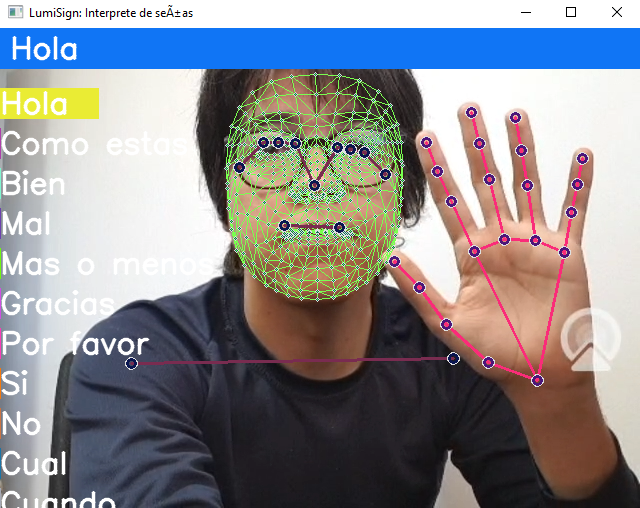

# 9. Make predictions

In [ ]:
# function to predict

def predict_action(sequence, model):
    sequence = np.expand_dims(sequence, axis=0)
    prediction = model.predict(sequence)[0]
    return prediction

# function to evaluate model

def run_evaluation():
    cap = cv2.VideoCapture(0)
    sequence = []
    sentence = []
    predictions = []
    prediction = None  # inicialize predict

    with mp.solutions.holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # make detections and extract keypoints
            image, results = mediapipe_detection(frame, holistic)
            draw_styled_landmarks(image, results)
            keypoints = extract_keypoints(results)
            sequence.append(keypoints)
            sequence = sequence[-60:]  # hold last 60 frames

            # only predict when have 60 frames in the sequence
            if len(sequence) == 60:
                prediction = predict_action(sequence, model)
                action = actions[np.argmax(prediction)]
                predictions.append(np.argmax(prediction))

                if np.unique(predictions[-10:])[0] == np.argmax(prediction):
                    if prediction[np.argmax(prediction)] > threshold:
                        if len(sentence) > 0:
                            if action != sentence[-1]:
                                sentence.append(action)
                        else:
                            sentence.append(action)
            
            if len(sentence) > 5:
                sentence = sentence[-5:]

            # Visualize probs
            if prediction is not None:
                image = prob_viz(prediction, actions, image, colors)

            cv2.rectangle(image, (0, 0), (640, 40), (245, 117, 16), -1)
            cv2.putText(image, ' '.join(sentence), (3, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            
            # show image
            cv2.imshow('LumiSign: Interprete de señas', image)

            # Exit press 'q'
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

    cap = cv2.VideoCapture(0)
    while True:
        ret, frame = cap.read()
        if not ret:
            print("No se pudo acceder a la cámara.")
            break
        cv2.imshow("Test", frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()